# **Setup and Import Libraries**

In [4]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text processing
import re
import string
import json
import requests
import pickle
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import download as nltk_download
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Download NLTK dependencies
nltk_download('punkt')
nltk_download('punkt_tab')
nltk_download('stopwords')

# Machine learning
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix

# Deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout,Flatten, GRU,SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Load Dataset**

In [5]:
# Load the dataset from a CSV file
url = "https://raw.githubusercontent.com/Firmnm/ShopeeReviewSentiment/main/Datasets/shopee_reviews.csv"
df = pd.read_csv(url)

In [6]:
# Display the first few rows
print("Sample data:")
df.head()

Sample data:


,content,score
0,aplikasi yang sangat bagus ayo download sekara...,5
1,mantul,5
2,shopee memang TERBAIK,5
3,kerennnn,5
4,"penjual banyak abal2,barang DTG sering tidak s...",1


# **Exploratory Data Analysis (EDA)**

* Dataset Overview






In [7]:
# Display basic information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  20000 non-null  object
 1   score    20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [8]:
# Check for Missing Values
print('Missing Values:')
print(df.isnull().sum())

Missing Values:
content    0
score      0
dtype: int64


* Sentiment Distribution

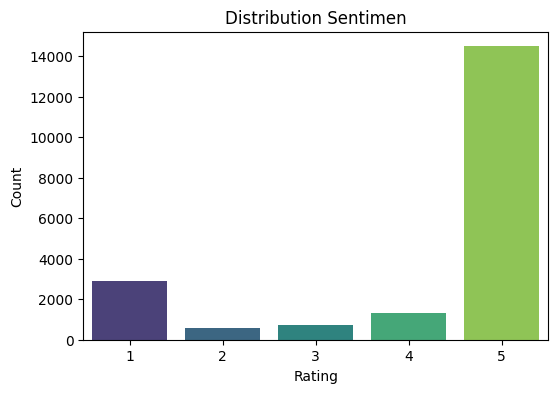

score
5    14480
1     2886
4     1333
3      740
2      561
Name: count, dtype: int64


In [9]:
# Check for Rating Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['score'], palette='viridis')
plt.title("Distribution Sentimen")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

print(df['score'].value_counts())

# **Text Preprocessing**

* *Cleaning Text*

In [10]:
# Clean text for sentiment analysis
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # Remove mentions (@username)
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)  # Remove hashtags (#hashtag)
    text = re.sub(r'[²]', ' ', text)  # Remove special characters
    text = re.sub(r'\d+', ' ', text)  # Remove numbers within words
    text = re.sub(r'[^\w\s]', ' ', text)  # Remove all punctuation, including commas
    text = text.strip()  # Remove extra spaces at the beginning and end
    text = text.lower()  # Convert text to lowercase

    return text

* *Tokenization*

In [11]:
# Tokenize the text into individual words
def tokenizing_text(text):
    text = word_tokenize(text)  # Split the text into tokens (words)
    return text

* *Stopword Removal*

In [12]:
# Remove stopwords from the text
def filtering_text(text):
    listStopwords = set(stopwords.words('indonesian'))  # Load Indonesian stopwords
    listStopwords1 = set(stopwords.words('english'))  # Load English stopwords
    listStopwords.update(listStopwords1)  # Combine Indonesian and English stopwords
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])  # Add custom stopwords

    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)

    text = filtered
    return text

* *Slang Word Normalization*

In [13]:
# Load slang words from a JSON file
def load_slangwords(url):
    return requests.get(url).json()

# GitHub raw URL for slangwords.json
url = "https://raw.githubusercontent.com/Firmnm/ShopeeReviewSentiment/main/Datasets/slangwords.json"
slangwords = load_slangwords(url)

In [14]:
# Replace slang words with their standard equivalents
def fix_slangwords(text):
    words = text.split()
    fixed_words = [slangwords[word.lower()] if word.lower() in slangwords else word for word in words]
    return ' '.join(fixed_words)

* *Reconstructing Cleaned Text*

In [15]:
# Combine a list of tokens into a single sentence
def to_sentence(tokens):
    return ' '.join(tokens)

In [16]:
# Clean the text and store it in the 'clean_text' column
df['clean_text'] = df['content'].apply(clean_text)

# Replace slang words with standard words and store them in 'text_slangwords'
df['text_slangwords'] = df['clean_text'].apply(fix_slangwords)

# Tokenize the text (split into words) and store it in 'text_tokenizing'
df['text_tokenizing'] = df['text_slangwords'].apply(tokenizing_text)

# Remove stopwords (common words) and store the result in 'text_stopword'
df['text_stopword'] = df['text_tokenizing'].apply(filtering_text)

# Join tokens into sentences and store them in 'clean_content'
df['clean_content'] = df['text_stopword'].apply(to_sentence)

* *Lexicon-Based Sentiment Analysis*

In [17]:
# Function to fetch lexicon data safely
def fetch_lexicon(url):
    response = requests.get(url)
    if response.status_code == 200:
        words = set(word.strip() for word in response.text.split("\n") if word.strip())
        return words
    else:
        print(f"Failed to fetch {url}, status code: {response.status_code}")
        return set()

# Download and load positive words lexicon
url_positive = "https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/positive.txt"
lexicon_positive = fetch_lexicon(url_positive)

# Download and load negative words lexicon
url_negative = "https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/negative.txt"
lexicon_negative = fetch_lexicon(url_negative)

# Print lexicon statistics
print(f"Total positive words: {len(lexicon_positive)}")
print(f"Total negative words: {len(lexicon_negative)}")

Total positive words: 1182
Total negative words: 2402


In [18]:
#Label sentiment based on lexicon
def get_sentiment(text):
    score = 0
    for word in text:
        if word in lexicon_positive:
            score += 1
        if word in lexicon_negative:
            score -= 1

    if score > 0:
        sentiment = 'positive'
    elif score < 0:
        sentiment = 'negative'
    else:
        sentiment = 'netral'

    return score, sentiment

In [19]:
# Apply sentiment labeling to the 'text_stopword' column
results = df['text_stopword'].apply(get_sentiment)
results = list(zip(*results))
df['sentiment_score'] = results[0]
df['sentiment'] = results[1]

# Display the count of each sentiment category
print(df['sentiment'].value_counts())

sentiment
netral      8927
positive    8709
negative    2364
Name: count, dtype: int64


* *Class Distribution*

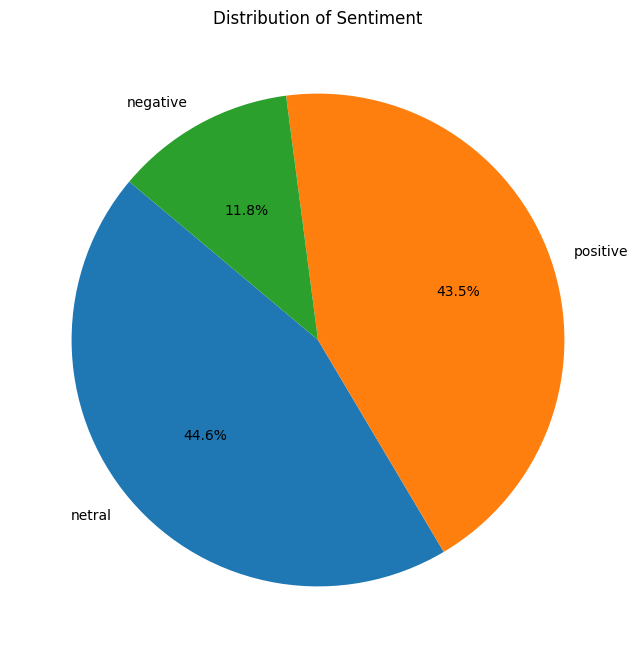

In [20]:
# Count the number of each sentiment category
polarity_counts = df['sentiment'].value_counts()

# Display pie chart of sentiment distribution
plt.figure(figsize=(8, 8))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiment')
plt.show()

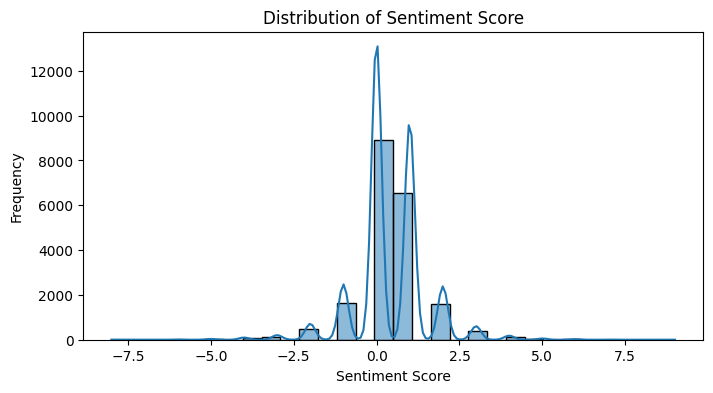

In [21]:
# Display the distribution of sentiment scores using a histogram
plt.figure(figsize=(8, 4))
sns.histplot(df['sentiment_score'], bins=30, kde=True)
plt.title('Distribution of Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

* *Text Length Analysis*

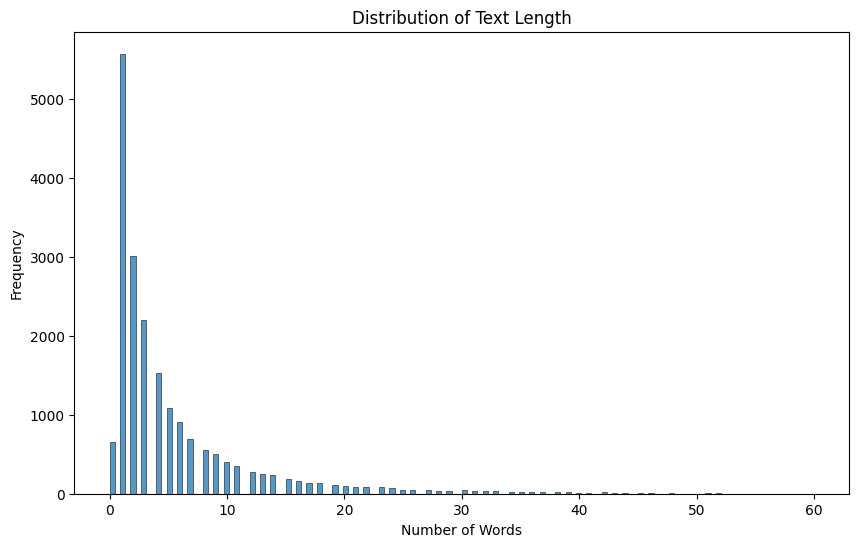

In [22]:
# Calculate text length based on the number of words
df['text_length'] = df['clean_content'].apply(lambda x: len(x.split()))

# Display the distribution of text length using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'])
plt.title('Distribution of Text Length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

* *Word Frequency Analysis*

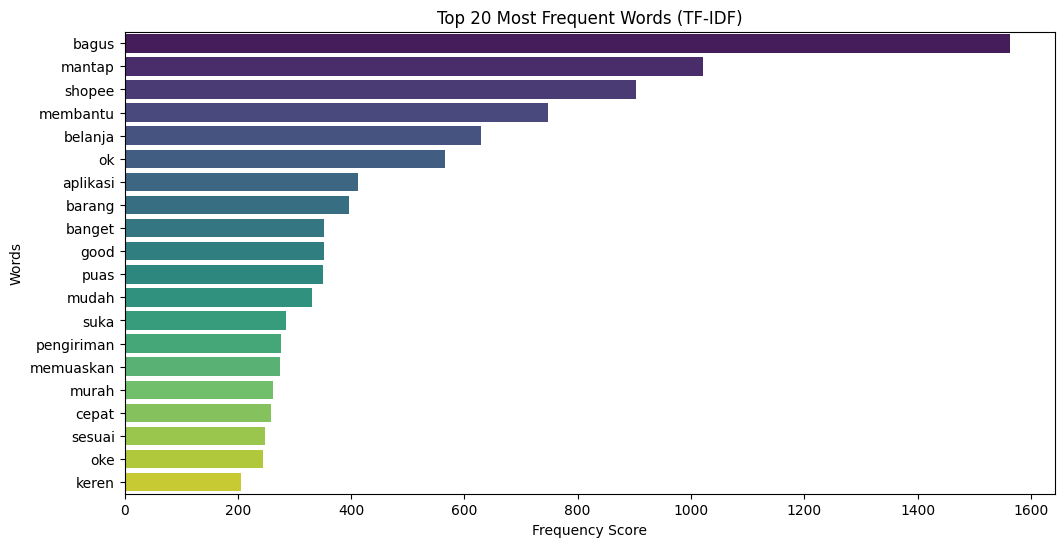

In [23]:
# Compute word frequency using TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['clean_content'])

# Extract top 20 most frequent words
word_frequencies = (
    pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    .sum()
    .nlargest(20)
)

# Visualize the most frequently occurring words
plt.figure(figsize=(12, 6))
sns.barplot(x=word_frequencies.values, y=word_frequencies.index, palette="viridis")
plt.title('Top 20 Most Frequent Words (TF-IDF)')
plt.xlabel('Frequency Score')
plt.ylabel('Words')
plt.show()

* ***WordCloud Visualization***


---



  1. *General Words Reviews*



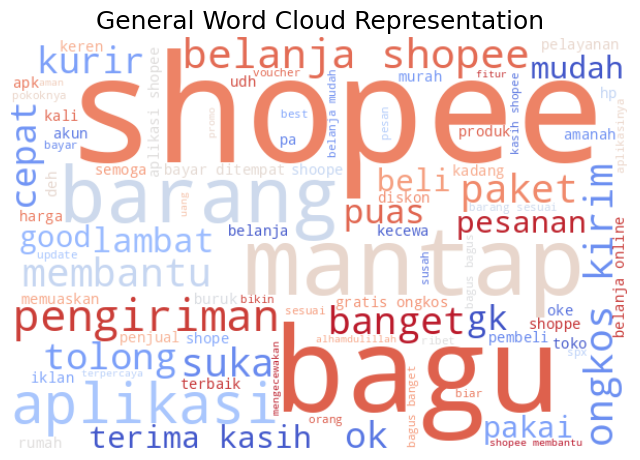

In [24]:
# Combine all words from 'clean_text' into a single string
df['text_stopword'] = df['text_stopword'].dropna().apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else str(x))
list_words = ' '.join(df['text_stopword'])

# Generate Wordcloud
wordcloud = WordCloud(width=600, height=400, background_color='white', colormap='coolwarm', min_font_size=10).generate(list_words)

# Plot Wordcloud
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('General Word Cloud Representation', fontsize=18)
plt.show()

2. *Netral Words Reviews*

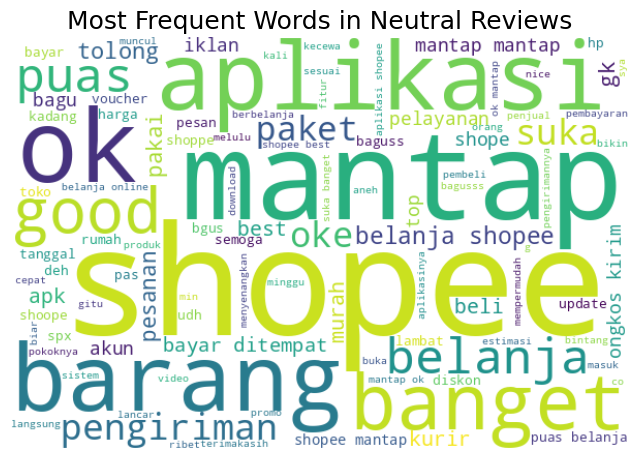

In [25]:
# Filter neutral sentiment data and sort by sentiment score
neutral_tweets = df[df['sentiment'] == 'netral'].sort_values(by='sentiment_score', ascending=False)

# Combine all words from 'text_stopword' into a single string
list_words = ' '.join(neutral_tweets['text_stopword'].explode().dropna().astype(str))

# Generate Wordcloud
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Plot Wordcloud
pd.set_option('display.max_colwidth', 3000)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Most Frequent Words in Neutral Reviews', fontsize=18)
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
plt.show()

3. *Positive Words Reviews*





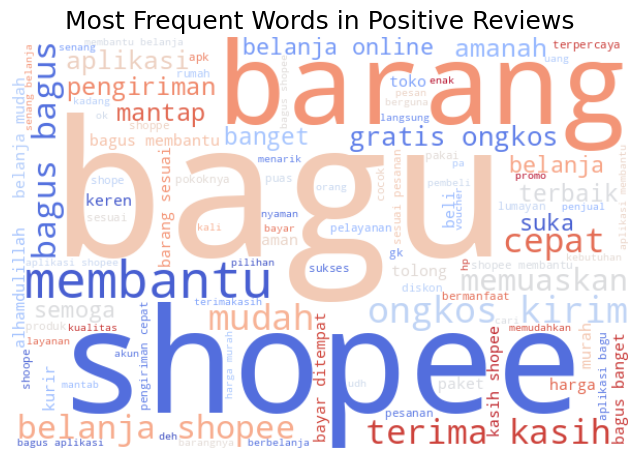

In [26]:
# Filter positive sentiment data and sort by sentiment score
positive_tweets = df[df['sentiment'] == 'positive'].sort_values(by='sentiment_score', ascending=False)

# Combine all words from 'text_stopword' into a single string
list_words = ' '.join(positive_tweets['text_stopword'].explode().dropna().astype(str))

# Generate Wordcloud
wordcloud = WordCloud(width=600, height=400, background_color='white', colormap='coolwarm', min_font_size=10).generate(list_words)

# Plot Wordcloud
pd.set_option('display.max_colwidth', 3000)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Most Frequent Words in Positive Reviews', fontsize=18)
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
plt.show()

4. *Negative Words Reviews*

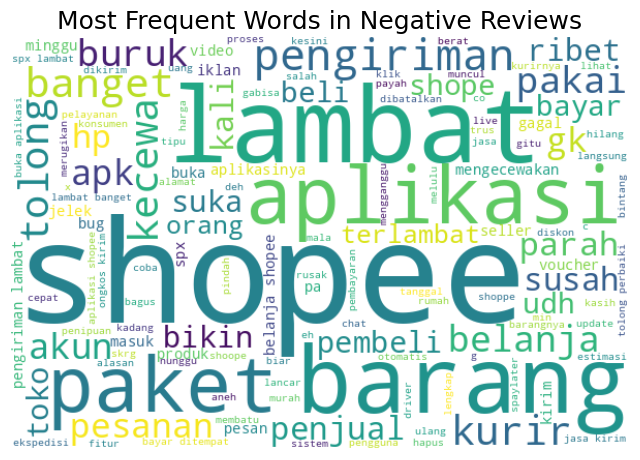

In [27]:
# Filter negative sentiment data and sort by sentiment score
negative_tweets = df[df['sentiment'] == 'negative'].sort_values(by='sentiment_score', ascending=False)

# Combine all words from 'text_stopword' into a single string
list_words = ' '.join(negative_tweets['text_stopword'].explode().dropna().astype(str))

# Generate Wordcloud
wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)

# Plot Wordcloud
pd.set_option('display.max_colwidth', 3000)
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Most Frequent Words in Negative Reviews', fontsize=18)
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
plt.show()

# **Data Preparation**

* *Feature & Label Extraction*



In [36]:
# Extract the 'clean_content' column as features (X) and 'sentiment' as labels (y)
X = df['clean_content']
y = df['sentiment'].map({'positive': 2, 'netral': 1, 'negative': 0})  # Ensure label consistency

# **Feature Engineering**

* *TF-IDF Vectorization*

In [37]:
# TF-IDF Vectorization for Traditional Machine Learning
tfidf = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf.fit_transform(X)
print(f"Summary of Features and Data:")
print(f"TF-IDF feature shape: {X_tfidf.shape}")

Summary of Features and Data:
TF-IDF feature shape: (20000, 10000)


* *Tokenization & Padding for LSTM*

In [38]:
# Text preprocessing for LSTM
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X, maxlen=100)

* *Displaying Vocabulary & Class Info*

In [39]:
# Get the number of unique sentiment classes
num_classes = len(np.unique(y))
print(f"Number of classes: {num_classes}")
print(f"Feature sequence shape: {X.shape}")

# Display vocabulary size
word_index = tokenizer.word_index
print(f"\nVocabulary size: {len(word_index)} words")

Number of classes: 3
Feature sequence shape: (20000, 100)

Vocabulary size: 10899 words


# **Model Training & Evaluation**

* ***Deep Learning Model (LSTM)***

In [40]:
# Split data into training, testing, and validation sets (70% training, 20% testing, 10% validation)
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(X_train_lstm, y_train_lstm, test_size=0.125, random_state=42)

# Display the total number of samples in each dataset
print("Total Samples:")
print(f"Training set: {X_train_lstm.shape[0]} samples")
print(f"Validation set: {X_val_lstm.shape[0]} samples")
print(f"Testing set: {X_test_lstm.shape[0]} samples")

Total Samples:
Training set: 14000 samples
Validation set: 2000 samples
Testing set: 4000 samples


In [41]:
# Initialize LSTM Model with Embedding and Hyperparameter Tuning
lstm_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),
    SpatialDropout1D(0.4),
    LSTM(128, dropout=0.3, recurrent_dropout=0.3),
    Dense(3, activation='softmax')
])

# Compile the Model
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Callbacks (EarlyStopping & ReduceLROnPlateau)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),  # Stop early to prevent overfitting
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# Train the Model
history = lstm_model.fit(X_train_lstm, y_train_lstm,
                         validation_data=(X_val_lstm, y_val_lstm),
                         epochs=15,
                         batch_size=64,
                         verbose=1,
                         callbacks=callbacks)

Epoch 1/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 120s 369ms/step - accuracy: 0.6313 - loss: 0.7584 - val_accuracy: 0.8965 - val_loss: 0.2865 - learning_rate: 0.0010
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 78s 352ms/step - accuracy: 0.9183 - loss: 0.2140 - val_accuracy: 0.9425 - val_loss: 0.1701 - learning_rate: 0.0010
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 76s 348ms/step - accuracy: 0.9652 - loss: 0.1030 - val_accuracy: 0.9520 - val_loss: 0.1461 - learning_rate: 0.0010
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 81s 347ms/step - accuracy: 0.9822 - loss: 0.0551 - val_accuracy: 0.9430 - val_loss: 0.1723 - learning_rate: 0.0010
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 75s 343ms/step - accuracy: 0.9864 - loss: 0.0432 - val_accuracy: 0.9535 - val_loss: 0.1578 - learning_rate: 0.0010


125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9406 - loss: 0.1782

LSTM Model Evaluation
Train accuracy per epoch: 0.9873
Test accuracy: 0.9438
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.88      0.86       475
     neutral       0.95      0.93      0.94      1806
    positive       0.97      0.97      0.97      1719

    accuracy                           0.94      4000
   macro avg       0.92      0.93      0.92      4000
weighted avg       0.94      0.94      0.94      4000



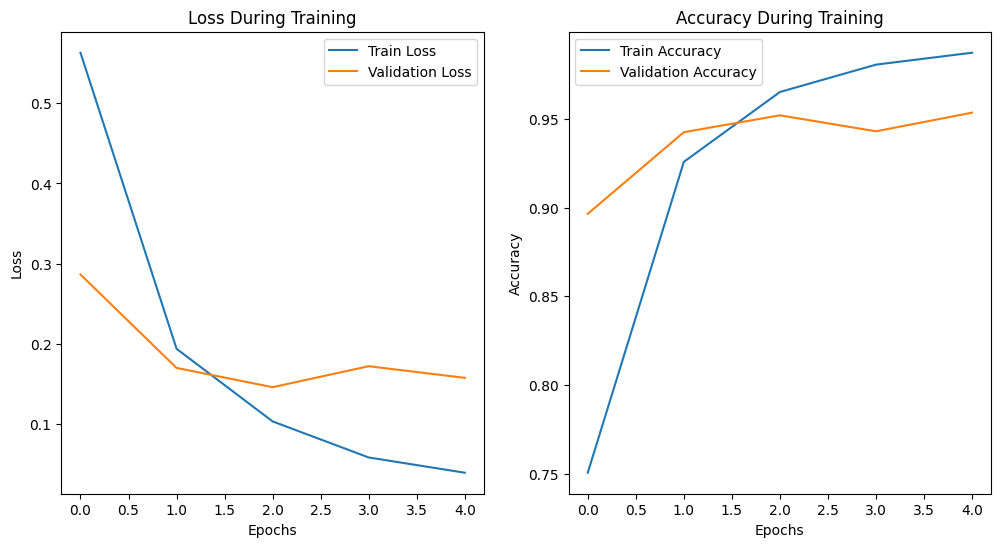

In [42]:
# Evaluate the Model
train_acc = history.history['accuracy']
test_loss, lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test_lstm)

print("\nLSTM Model Evaluation")
print(f"Train accuracy per epoch: {train_acc[-1]:.4f}")
print(f"Test accuracy: {lstm_accuracy:.4f}")

# Generate classification report
y_pred = np.argmax(lstm_model.predict(X_test_lstm), axis=1)  # Get predicted class indices
print("\nClassification Report:")
print(classification_report(y_test_lstm, y_pred, target_names=['negative', 'neutral', 'positive']))

# Plot training loss and accuracy
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

* ***Traditional Machine Learning Models***

1. SVM + TF-IDF (80/20)

In [43]:
# Split Data into Training and Testing sets (80% training, 20% testing)
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

print("Total Samples:")
print(f"Training set: {X_train_svm.shape[0]} samples")
print(f"Test set: {X_test_svm.shape[0]} samples")

Total Samples:
Training set: 16000 samples
Test set: 4000 samples


In [44]:
# Initialize SVM Model with Linear Kernel
svm_model = SVC(kernel='linear', probability=True)

# Train the Model
svm_model.fit(X_train_svm, y_train_svm)

# Make Predictions
y_pred_svm = svm_model.predict(X_test_svm)


SVM + TF-IDF Model Evaluation

Train Accuracy: 0.9804
Test Accuracy: 0.9335

Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.79      0.84       475
     neutral       0.90      0.96      0.93      1806
    positive       0.98      0.94      0.96      1719

    accuracy                           0.93      4000
   macro avg       0.93      0.90      0.91      4000
weighted avg       0.93      0.93      0.93      4000



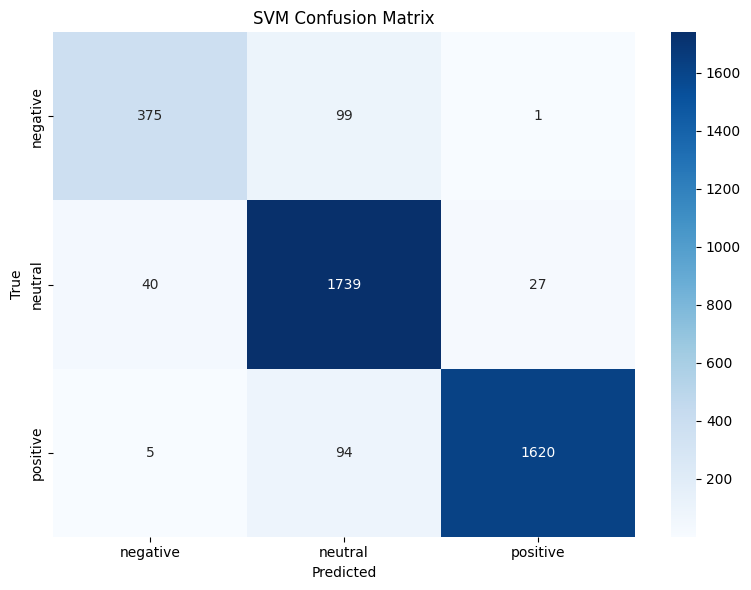

In [45]:
# Model Evaluation
train_acc_svm = accuracy_score(y_train_svm, svm_model.predict(X_train_svm))
svm_accuracy = accuracy_score(y_test_svm, y_pred_svm)

print("\nSVM + TF-IDF Model Evaluation")
print(f'\nTrain Accuracy: {train_acc_svm:.4f}')
print(f'Test Accuracy: {svm_accuracy:.4f}')

print("\nClassification Report:")
print(classification_report(y_test_svm, y_pred_svm, target_names=['negative', 'neutral', 'positive']))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_svm, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

2. Random Forest + TF-IDF (70/30)

In [46]:
# Split Data into Training and Testing sets (70% Training, 30% Testing)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

print("Total Samples: ")
print(f"Training set: {X_train_rf.shape[0]} samples")
print(f"Test set: {X_test_rf.shape[0]} samples")

Total Samples: 
Training set: 14000 samples
Test set: 6000 samples


In [47]:
# Initialize Random Forest Model with Hyperparameter Tuning
rf_model = RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=5, min_samples_leaf=2, random_state=42)

# Train the Model
rf_model.fit(X_train_rf, y_train_rf)

# Make Predictions
y_pred_rf = rf_model.predict(X_test_rf)


Random Forest Model Evaluation with TF-IDF
Training Accuracy: 0.9362
Testing Accuracy: 0.9067

Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.72      0.78       721
     neutral       0.90      0.91      0.91      2713
    positive       0.93      0.95      0.94      2566

    accuracy                           0.91      6000
   macro avg       0.89      0.86      0.87      6000
weighted avg       0.91      0.91      0.91      6000



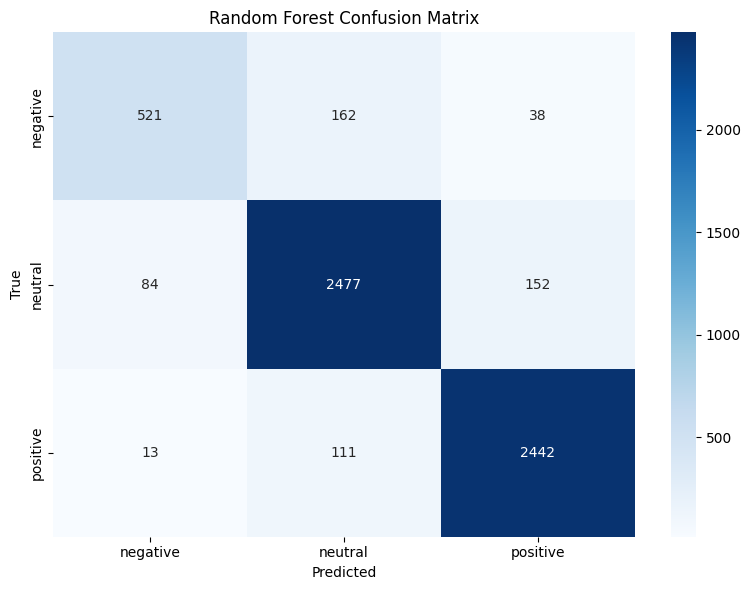

In [48]:
# Model Evaluation
train_acc = accuracy_score(y_train_rf, rf_model.predict(X_train_rf))
rf_accuracy = accuracy_score(y_test_rf, y_pred_rf)

print("\nRandom Forest Model Evaluation with TF-IDF")
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {rf_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_rf, y_pred_rf, target_names=['negative', 'neutral', 'positive']))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_rf, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


* *Model Comparison*

In [51]:
# Create a summary table for model performance
summary = {
    'Model': ['LSTM + Embedding (80/20)','SVM + TF-IDF (80/20)', 'RF + TF-IDF (70/30)'],
    'Accuracy': [lstm_accuracy, svm_accuracy, rf_accuracy],
    'Split Ratio': ['80/20', '80/20', '70/30'],
    'Feature Type': ['Word Embedding', 'TF-IDF', 'TF-IDF']
}

# Convert to a DataFrame
df_summary = pd.DataFrame(summary)

# Format accuracy values to 4 decimal places
df_summary['Accuracy'] = df_summary['Accuracy'].apply(lambda x: f"{x:.2%}")

# Display the summary of results
print("Summary of Results")
display(df_summary)

Summary of Results


,Model,Accuracy,Split Ratio,Feature Type
0,LSTM + Embedding (80/20),94.38%,80/20,Word Embedding
1,SVM + TF-IDF (80/20),93.35%,80/20,TF-IDF
2,RF + TF-IDF (70/30),90.67%,70/30,TF-IDF


# Save Models for Inference

In [53]:
# Save LSTM Model
lstm_model.save("lstm_sentiment_model.h5")

# Save SVM Model
with open("svm_sentiment_model.pkl", "wb") as f:
    pickle.dump(svm_model, f)

# Save Random Forest Model
with open("rf_sentiment_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

# Save TF-IDF Vectorizer
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

# Save Tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Summary & Conclution

**Summary**  



The sentiment analysis results using different models and feature extraction techniques are as follows:  

- **LSTM + Embedding (80/20)** achieved the highest accuracy of **94.38%**, indicating that deep learning with word embedding representation effectively captures sentiment patterns better than traditional methods.  
- **SVM + TF-IDF (80/20)** obtained **93.35%** accuracy, demonstrating that SVM-based models perform well with TF-IDF features in sentiment analysis.  
- **Random Forest (RF) + TF-IDF (70/30)** recorded an accuracy of **90.67%**, which is still relatively high but lower than the other models. The lower performance could be attributed to the choice of algorithm or the different data split ratio (**70/30** compared to **80/20** for the other models).  

---

**Conclusion**  
From the results, we can conclude that:  

1. **LSTM with word embedding provides the best performance**, achieving the highest accuracy (**94.38%**). This suggests that deep learning models can capture word relationships more effectively than traditional TF-IDF-based models.  
2. **SVM with TF-IDF is a strong alternative**, with an accuracy of **93.35%**, slightly lower than LSTM. It remains a viable choice for sentiment analysis, especially when computational efficiency is a concern.  
3. **Random Forest with TF-IDF has the lowest accuracy among the three models** but still performs well (**90.67%**). This model may be preferable when interpretability is prioritized over maximum accuracy.  
4. **Dataset split ratio influences model performance**, as models trained with an **80/20** split tend to achieve higher accuracy than those using a **70/30** split. This could be due to having more training data available.  

Based on these findings, **LSTM with word embedding is recommended as the primary model for sentiment analysis** if accuracy is the main priority, while **SVM + TF-IDF is a computationally efficient alternative**.

**Future Improvements**  

1. **Hyperparameter Tuning** – Optimize LSTM layers, dropout rates, and SVM/RF parameters for better accuracy.  
2. **Advanced Features** – Use pre-trained embeddings (Word2Vec, GloVe), n-grams, and character-level features.  
3. **Hybrid Models** – Combine LSTM with SVM/RF or use ensemble methods for better performance.  
4. **Data Augmentation** – Apply synonym replacement, back-translation, and synthetic data generation.   
6. **Better Data Splitting** – Experiment with different train-test ratios and apply cross-validation.  


These improvements can enhance accuracy, robustness, and generalization of sentiment analysis models.